# Predicting Forest Fires in Algeria

## Introduction

Climate change has drastically increased the risk and extent of forest fires in several places around the world. Forest fires have numerous devastating effects such as the destruction of wildlife habitat and animal life, toxic gas emission to the atmosphere, infrastructure damage and could potentially cost human lives in the wake of a fire. Recognizing the potentially catastrophic effects of forest fires, it is vital to have some sort of early warning system that can help governmental agencies in forecasting forest fires.

<p float="left">
  <img src = "https://www.lifeinsuranceinternational.com/wp-content/uploads/sites/8/2019/02/shutterstock_710588224.jpg" width = "300"/>
  <img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQkiv3dvAtycEW-ZvEomKQXvL38bNuSKx1sOQ&usqp=CAU" width = "350" height = 265/>
  <img src = "https://i.natgeofe.com/n/77462492-ea41-41fe-9c07-296dc330181f/80133.jpg" width = "260"/>
</p>

This prompts us to question: *Can we predict the occurrence of forest fires base on certain weather metrics? If so, what are the metrics (variables) that create the most optimal predictive model?*
With that motivation in mind, this project aims to develop a k-nearest neighbours machine learning model that can predict whether or not a forest fire will occur based on various weather metrics. Our dataset is obtained from <https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++#>. This is a grouped dataset that contains observations from two different regions of Algeria, namely the Bejaia region in the northeast and the Siddi Bel-Abbes region in the northwest.

The dataset contains 14 columns:
* Day (day)
* Month (month): June to September
* Year (year): 2012
* Temperature: maximum temperature at noon, in degree Celsius (range: 22 -40)
* Relative humidity (RH): relative humidity in % (range: 21 - 90)
* Windspeed (Ws): in speed in km/h (range: 6 - 29)
* Rain amount (Rain): rain amount in a day, in milimeters (mm) (range: 0 - 16.8)
* Fine Fuel Moisture Code (FFMC) index from the FWI system (range: 28.6 - 92.5)
* Duff Moisture Code (DMC) index from the FWI system (range: 1.1 - 65.9)
* Drought Code (DC) index from the FWI system (range: 7 - 220.4)
* Initial Spread Index (ISI) index from the FWI system (range: 0 - 18.5)
* Buildup Index (BUI) index from the FWI system (range: 1.1 - 68)
* Fire Weather Index (FWI) Index (range: 0 - 31.1)
* Classes: fire/not fire

We will choose the predictors through the process of *forward selection* to obtain the combination of variables that yield the best prediction accuracy.

## Methods & Results

### Overview of our Methodology

The Algerian Forest Fire dataset provides us with two different regions to account for: __Bejaia__ and __Sidi-Bel Abbes__. Our team decided to combine the two regions to create more comprehensive data to better equip our model. Here is an overview of our data analysis methodology (detailed explanation will be presented at each step):
<ol>
<li><strong>Reading & Wrangling:</strong> read and wrangle the dataset into one tidy combined dataset of the two regions.</li>
<li><strong>Train/Test split:</strong> spliting the tidy dataframe into a training set and testing set, then summarizing the sample statistics of the training data.</li>
<li><strong>Predictor variables selection:</strong> find the combination of predictors that yield the relatively highest prediction accuracy, by using forward selection.</li>
<li><strong>K-Nearest Neighbor classification:</strong> model tuning with cross-validation, reconfigure and re-train the model with the best K parameter, predict the test set for final model accuracy validation.</li>
<li><strong>Results and Conclusion</strong></li>    
</ol>

### Loading relevant libraries

In [2]:
library(tidyverse)
library(tidymodels)
library(forcats)
library(RColorBrewer)
library(repr)
library(ggplot2)
library(knitr)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Reading & Wrangling our dataset from the web into R

* Due to there being 2 datasets in a single .csv file, we read them separately and then merged both of them into a single dataframe called "forest_fires".
* The dataset for <strong>Bejaia</strong> region has 1 line of metadata and a total of 122 rows therefore <code>skip = 1</code> and <code>n_max = 122</code> were used as arguments.
* The dataset for <strong>Sidi-Bel</strong> region started after 126 rows of the csv file therefore <code>skip = 126</code> was used as an argument.
* Since there was a missing value in one of the rows, the <code>na.omit()</code> function was used to get rid of that row.  
* The columns which had numerical values but were of a different type due to misinputs were converted back into numerical variables using <code>as.numeric()</code>.
* The rows of both the regions were combined to form one dataset using <code>rbind()</code>.
* The Class column will be our target variable for this analysis therefore it was converted into a factor variable using <code>as_factor()</code>.
* The region column was created to identify which observation belonged to which region. It was bound to the dataset using <code>cbind()</code> where 122 of the observations were of the <strong>Bejaia</strong> region and 121 observations were of the <strong>Sidi-Bel</strong> region.
* The resulting dataset is our wrangled <code>forest_fires</code> dataset with **243** useful observations.

In [3]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

Bej_data <- read_csv(url, skip = 1, n_max = 122)

SB_data <- read_csv(url, skip = 126) %>% 
    na.omit() %>% 
    mutate(DC = as.numeric(DC),
           FWI = as.numeric(FWI))

forest_fires <- rbind(Bej_data, SB_data) %>% 
    mutate(day = as.numeric(day),
           month = as.numeric(month),
           Classes = as_factor(Classes))

forest_fires <- cbind(region = (c(rep("Bejaia", 122), rep("Sidi-Bel Abbes", 121))), forest_fires)

forest_fires

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

region,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Bejaia,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
Bejaia,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
Bejaia,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sidi-Bel Abbes,28,9,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
Sidi-Bel Abbes,29,9,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire
Sidi-Bel Abbes,30,9,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire


### Summarizing the Training Data

* Based on our data wrangling step, we have a total of **243** usable observations.
* Thus, we have made a random split of **0.75**, which means 75% of the data is split into the training set and the remaining 25% into the test set to ensure that we have an adequate amount of observations for training and evaluating the prediction accuracy of our model.
* We also used <code>set.seed()</code> for reproducible results as <code>initial_split()</code> randomly samples from the dataframe.

In [4]:
set.seed(1234)
ff_split <- initial_split(forest_fires, prop = 0.75, strata = Classes)
ff_train <- training(ff_split)
ff_test <- testing(ff_split)

* Now we begin exploratory data analysis by summarizing the data into different types of tables.

In [5]:
n_per_class <- ff_train %>% 
    group_by(Classes) %>% 
    summarize(n = n())

`summarise()` ungrouping output (override with `.groups` argument)



<div align="center"> Table 1.1: Total Fire/Not Fire cases </div>

|Classes  |   n|
|:--------|---:|
|not fire |  80|
|fire     | 103|


* Table 1.1 reports the number of observations in each class (not fire or fire).
* Using <code>group_by(Classes)</code>, we grouped our table by the Class variable and then applied <code>n()</code> to count the number of observations in each class.
* It is observed that there are slightly more cases of Fires as compared to Not Fires in our training dataset.

In [6]:
n_per_class_region <- ff_train %>% 
    group_by(region, Classes) %>% 
    summarize(n = n())

`summarise()` regrouping output by 'region' (override with `.groups` argument)



<div align="center"> Table 1.2: Fire/Not fire cases in each region </div>

|region         |Classes  |  n|
|:--------------|:--------|--:|
|Bejaia         |not fire | 45|
|Bejaia         |fire     | 49|
|Sidi-Bel Abbes |not fire | 35|
|Sidi-Bel Abbes |fire     | 54|

* Table 1.2 reports the number of observations in each class for each region.
* Using <code>group_by(region, Classes)</code>, we obtain the total number of Fire and Not Fire cases for each of the regions.
* Table 1.2 suggests that there were more Fire cases in both the regions but the Fire cases were relatively greater in Sidi-Bel Abbes.

In [7]:
avg_pred_vals <- ff_train %>% 
    select(-day, -month, -year, -Classes, -region) %>% 
    map_df(mean, na.rm = TRUE)

<div align="center"> Table 1.3: Mean statistics for each potential predictor </div>

| Temperature|       RH|       Ws|      Rain|     FFMC|      DMC|       DC|      ISI|      BUI|      FWI|
|-----------:|--------:|--------:|---------:|--------:|--------:|--------:|--------:|--------:|--------:|
|    32.23497| 62.43716| 15.55738| 0.6612022| 78.22131| 14.15027| 48.95355| 4.653005| 16.21093| 6.839891|

* Table 1.3 reports the means of the predictor variables for all regions.
* Here, we select all the predictor variables and apply <code>map_df</code> to apply <code>mean()</code> to each of the columns in order to obtain the mean statistic for each variable.

In [8]:
bej_avg_pred_vals <- ff_train %>% 
    filter(region == "Bejaia") %>%
    select(-day, -month, -year, -Classes) %>% 
    map_df(mean, na.rm = TRUE) %>% 
    mutate(region = c("Bejaia"))

sid_avg_pred_vals <- ff_train %>% 
    filter(region == "Sidi-Bel Abbes") %>%
    select(-day, -month, -year, -Classes) %>% 
    map_df(mean, na.rm = TRUE) %>% 
    mutate(region = c("Sidi-Bel Abbes"))

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


<div align="center"> Table 1.4: Mean statistics for each potential predictor in Bejaia </div>

|region | Temperature|       RH|      Ws|      Rain|     FFMC|      DMC|       DC|      ISI|      BUI|      FWI|
|:------|-----------:|--------:|-------:|---------:|--------:|--------:|--------:|--------:|--------:|--------:|
|Bejaia |    31.57447| 67.59574| 16.1383| 0.6361702| 76.09681| 12.66277| 54.82447| 3.847872| 15.87766| 5.844681|

<div align="center"> Table 1.5:  Mean statistics for each potential predictor in Sidi-Bel Abbes </div>

|region         | Temperature|       RH|       Ws|      Rain|     FFMC|      DMC|       DC|      ISI|      BUI|      FWI|
|:--------------|-----------:|--------:|--------:|---------:|--------:|--------:|--------:|--------:|--------:|--------:|
|Sidi-Bel Abbes |    32.93258| 56.98876| 14.94382| 0.6876404| 80.46517| 15.72135| 42.75281| 5.503371| 16.56292| 7.891011|


* Tables 1.4 and 1.5 report the means of the predictor variables for the each region.
* The following tables help us to compare the summary statistics for each region.
* There is no clear difference in these statistics between the two regions suggesting to us that we need to conduct further analysis to distinguish the significant predictors.

### Predictor Variable Selection

* We begin our data analysis by tuning our classifier to choose which variables from our data will be treated as predictor variables. 
* We want to find out if there are any irrelevant predictors in our data set which will negatively impact our classifier. 
* To ensure that the choice of which variables to include as predictors is part of tuning our classifier, we conduct this on our __training set__.
* In order to the best predictors, we will use the _forward selection method_.
<ol>
<li>start with a model having no predictors</li>
<li>run the following 3 steps until you run out of predictors:</li>
    <ol>
        <li>for each unused predictor, add it to the model to form a candidate model</li>
        <li>tune all of the candidate models</li>
        <li>update the model to be the candidate model with the highest cross-validation accuracy</li>
    </ol>
<li>select the model that provides the best trade-off between accuracy and simplicity</li>
</ol>
  
  
__Note: We will be selecting the 3 best predictors according to this method in our code so that it runs relatively faster than the code for 10 predictors. This is done to save time however we will also be providing the resulting accuracy table for all predictors in the model after.__

In [9]:
set.seed(1)

ff_subset1 <- ff_train %>% select(FFMC,ISI,Rain,FWI,Classes)
names1 <- colnames(ff_subset1 %>% select(-Classes))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
ff_vfold <- vfold_cv(ff_subset1, v = 5, strata = Classes)

# store the total number of predictors
n_total <- length(names1)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names1)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names1[[j]])
        model_string <- paste("Classes", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        ff_recipe <- recipe(as.formula(model_string), data = ff_subset1) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(ff_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = ff_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names1[[jstar]])
    names1 <- names1[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Classes ~ FFMC,0.9834835
2,Classes ~ FFMC+ISI,0.9779279
3,Classes ~ FFMC+ISI+Rain,0.9782282
4,Classes ~ FFMC+ISI+Rain+FWI,0.9728228


* Table 1.6 below represents the models and their respective accuracies for __ALL__ predictor variables.
* As meaningful predictors are added, the estimated accuracy increases substantially; whereas adding irrelevant variables causes the accuracy to either exhibit small fluctuations or decrease as the model attempts to tune the number of neighbours to account for the extra noise.
* Naturally, we balance high accuracy with simplicity. Keeping this in mind, we find the best model by observing the point where the accuracy stops increasing dramatically and levels off or begins to decrease. Therefore, we chose __FFMC, ISI and RAIN__ as our predictors since the accuracy starts to decrease as you add more and more predictors to the model.

<div align="center"> Table 1.6: Accuracy versus the number of predictors in the model. </div>

| size|model_string                                             |  accuracy|
|----:|:--------------------------------------------------------|---------:|
|    1|Classes ~ FFMC                                           | 0.9834835|
|    2|Classes ~ FFMC+ISI                                       | 0.9779279|
|    3|Classes ~ FFMC+ISI+Rain                                  | 0.9782282|
|    4|Classes ~ FFMC+ISI+Rain+FWI                              | 0.9728228|
|    5|Classes ~ FFMC+ISI+Rain+FWI+DMC                          | 0.9728228|
|    6|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC                       | 0.9674174|
|    7|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC+BUI                   | 0.9674174|
|    8|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC+BUI+Ws                | 0.9507508|
|    9|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC+BUI+Ws+RH             | 0.9510511|
|   10|Classes ~ FFMC+ISI+Rain+FWI+DMC+DC+BUI+Ws+RH+Temperature | 0.9345345|

### Visualizing the best predictors in the Training Data

* The histograms depicted below represent the distributions of the top 4 predictor variables according to the forward selection method.
* We use histograms because we are creating a visualization for the distribution of **numerical** data.
* Each histogram shows the distribution of each predictor, each colour representing each region.

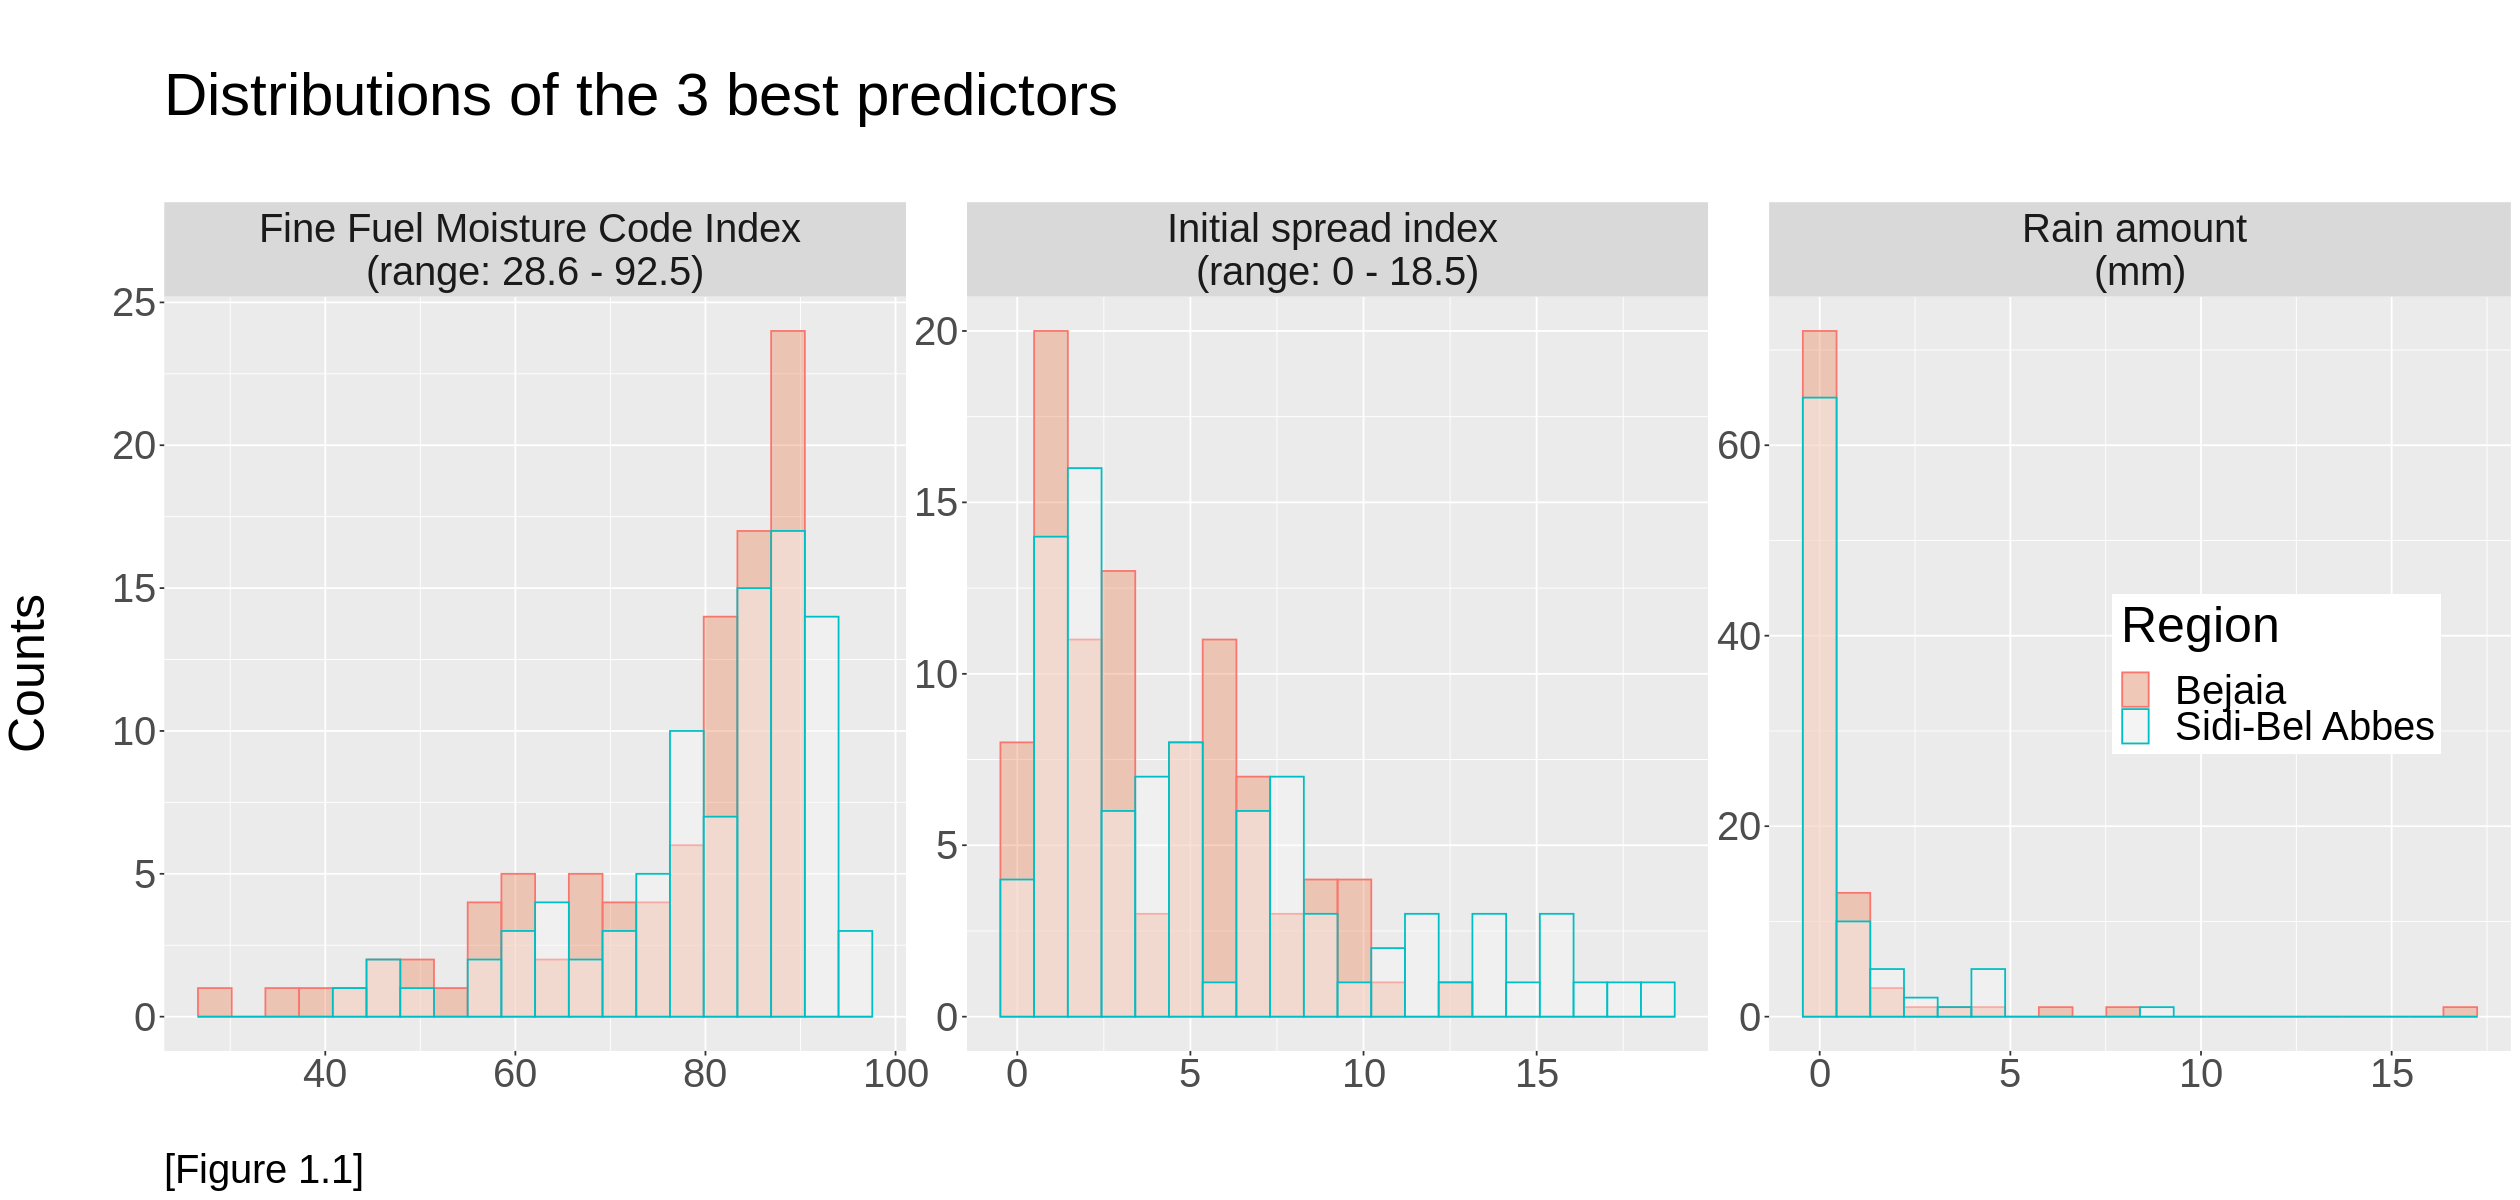

In [10]:
options(repr.plot.width = 21, repr.plot.height = 10)

a <- ff_train %>%
    select(region,FFMC,ISI,Rain,Classes) %>% 
    pivot_longer(cols = FFMC:Rain,
                 names_to = "predictors",
                 values_to = "values")

predictor_labels <- c(FFMC = "Fine Fuel Moisture Code Index \n(range: 28.6 - 92.5)",
                   ISI = "Initial spread index \n(range: 0 - 18.5)",
                   Rain = "Rain amount \n(mm)")

distribution_plot <- a %>%
    ggplot(aes(x = values, fill = region, colour = region)) + 
    geom_histogram(alpha = 0.4, position = 'identity', bins = 20) +
    labs(x = "",
         y = "Counts\n",
         fill = "Region",
         colour = "Region",
         title = "\nDistributions of the 3 best predictors\n",
         caption = "[Figure 1.1]") +
    facet_wrap(vars(predictors), 
               scales = "free",
               labeller = labeller(predictors = predictor_labels)) +
    theme(strip.text.y.left = element_text(angle = 0),
          legend.position = c(0.90, 0.50),
          plot.caption = element_text(hjust = 0),
          text = element_text(size = 30)) +
    scale_fill_brewer(palette = "RdBu") # To see more colorblind friendly pallete: display.brewer.all(colorblindFriendly = T)


distribution_plot

__Visualization analysis of Figure 1.1:__
* <strong>FFMC:</strong> Left-skewed, most observations for the two regions separately or combined together have a very high FFMC value
* <strong>ISI:</strong> Slightly right-skewed, most observations from the two regions separately or combined have medium to low ISI value
* <strong>Rain amount:</strong> Extremely right-skewed, most observations from the two regions separately or combined have very little to no rain
* Overall the two regions share very similar frequency distributions for each of the predictors.

### Tuning our K-NN Classifier

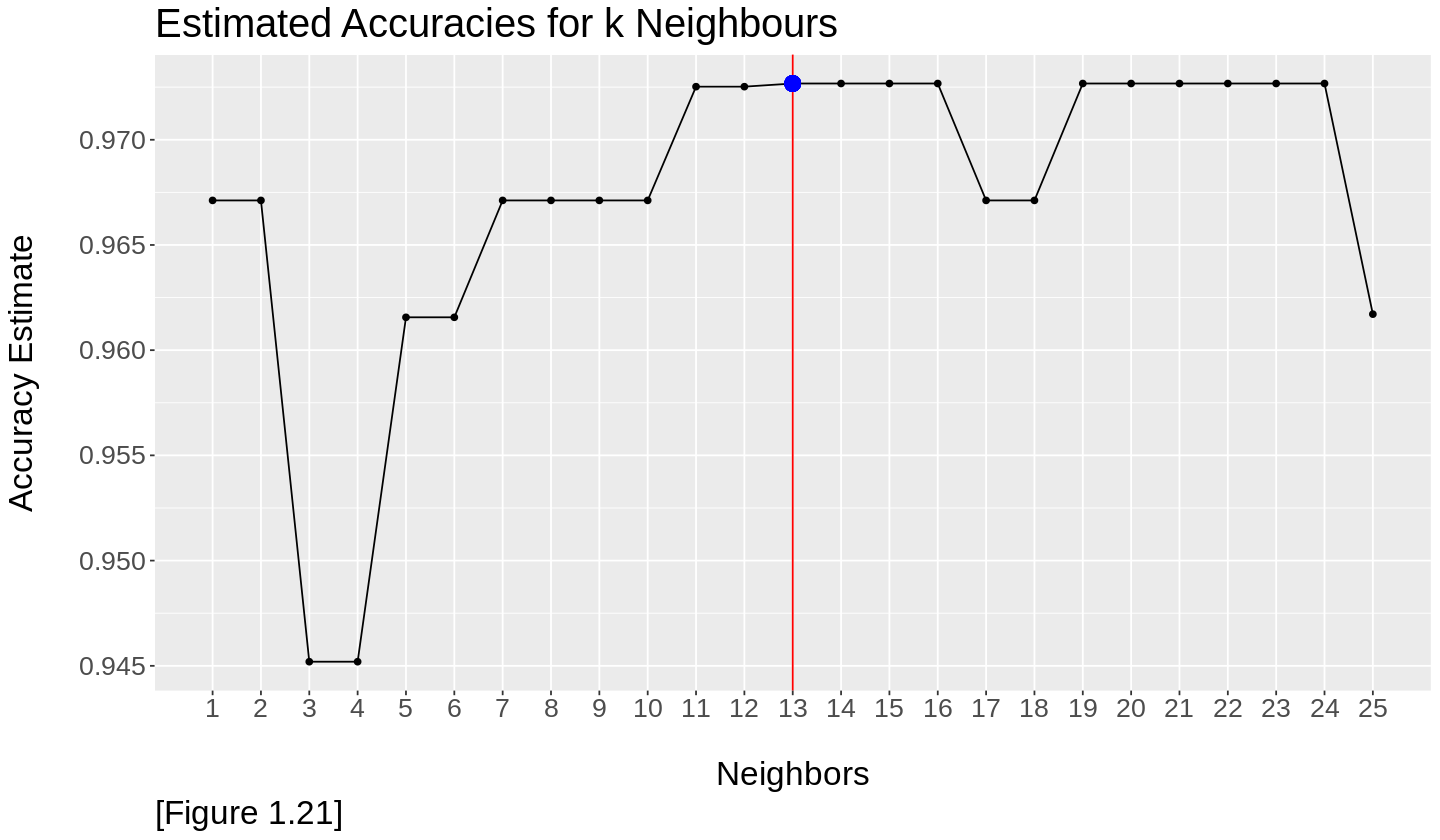

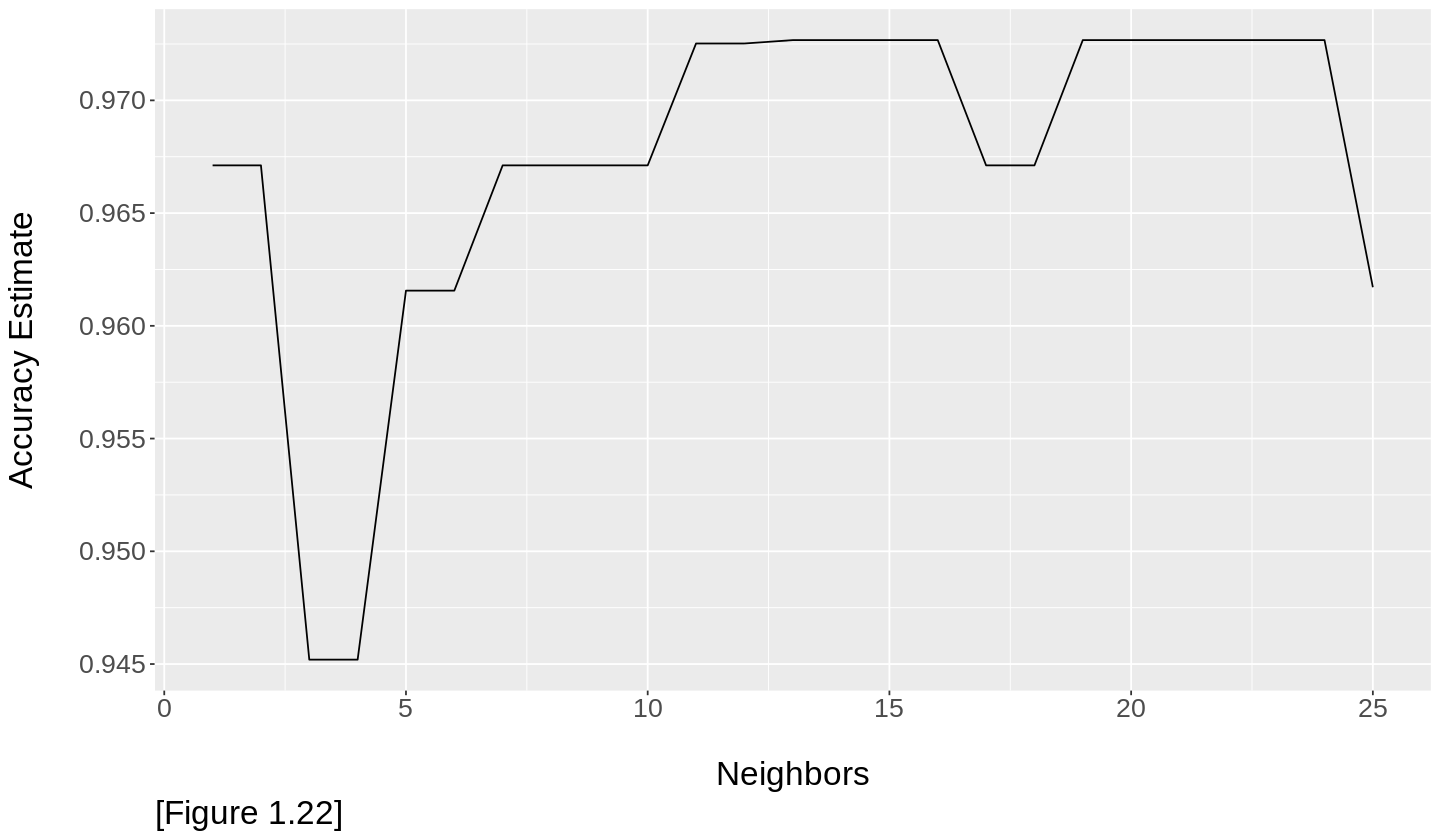

In [17]:
set.seed(1)

ff_recipe <- recipe(Classes ~ FFMC + ISI + Rain, data = ff_train) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

ff_vfold <- vfold_cv(ff_train, v = 5, strata = Classes)
gridvals <- tibble(neighbors = seq(1, 25))

ff_results <- workflow() %>% 
    add_recipe(ff_recipe) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = ff_vfold, grid = gridvals) %>% 
    collect_metrics() %>% 
    filter(.metric == "accuracy")

options(repr.plot.width = 12, repr.plot.height = 7)

ky <- ff_results %>% filter(neighbors == 13) %>% select(mean) %>% pull()

cross_val_plot <- ff_results %>% 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 13, colour = "red") +
    geom_point(aes(x=13, y= ky), size = 4, colour = "blue") +
    labs(x = "\nNeighbors",
         y = "Accuracy Estimate\n",
         title = "Estimated Accuracies for k Neighbours",
         caption = "[Figure 1.21]") +
    scale_x_continuous(limits = c(1, 25), breaks = seq(1, 25), minor_breaks = seq(1, 25, 1)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))

cross_val_plot

gridvals1 <- tibble(neighbors = seq(1, 50))
ff_results %>% 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    labs(x = "\nNeighbors",
         y = "Accuracy Estimate\n",
         caption = "[Figure 1.22]") +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))
    

* We now conduct the K-NN classification analysis on our dataset with predictors: __FFMC, ISI and Rain__.
* To do this, we:
<ol>
    <li>Define a recipe with the predictors: <strong>FFMC, ISI and Rain</strong>. We further scale and center our predictors.</li>
    <li>Define the specification for our k-nn model. We use <code>tune()</code> for the neighbours argument because we will first tune our model to choose the best k-value for our model.</li>
    <li>Perform cross-validation with <strong>5</strong> folds. This is because our dataset is not too large so 20% of the data for validation is considerably accurate. </li>
    <li>Create a workflow adding the recipe and the model and applying the <code>tune_grid()</code> function for cross-validation. We then collect the resulting accuracies with the <code>collect_metrics()</code> function.</li>
    <li>Finally, in we plot the accuracies against the neighbours in order to visualize the most stable k nearest neighbour.</li>
</ol>
  
Figure 1.2 demonstrates that <strong>k = 13</strong> is the most optimal value. This is because it is relatively higher than most other neighbours and does not immediately fall as we increase or decrease the neighbour by 1.

### KNN Classification

Warning message in pal_name(palette, type):
“Unknown palette Mint”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



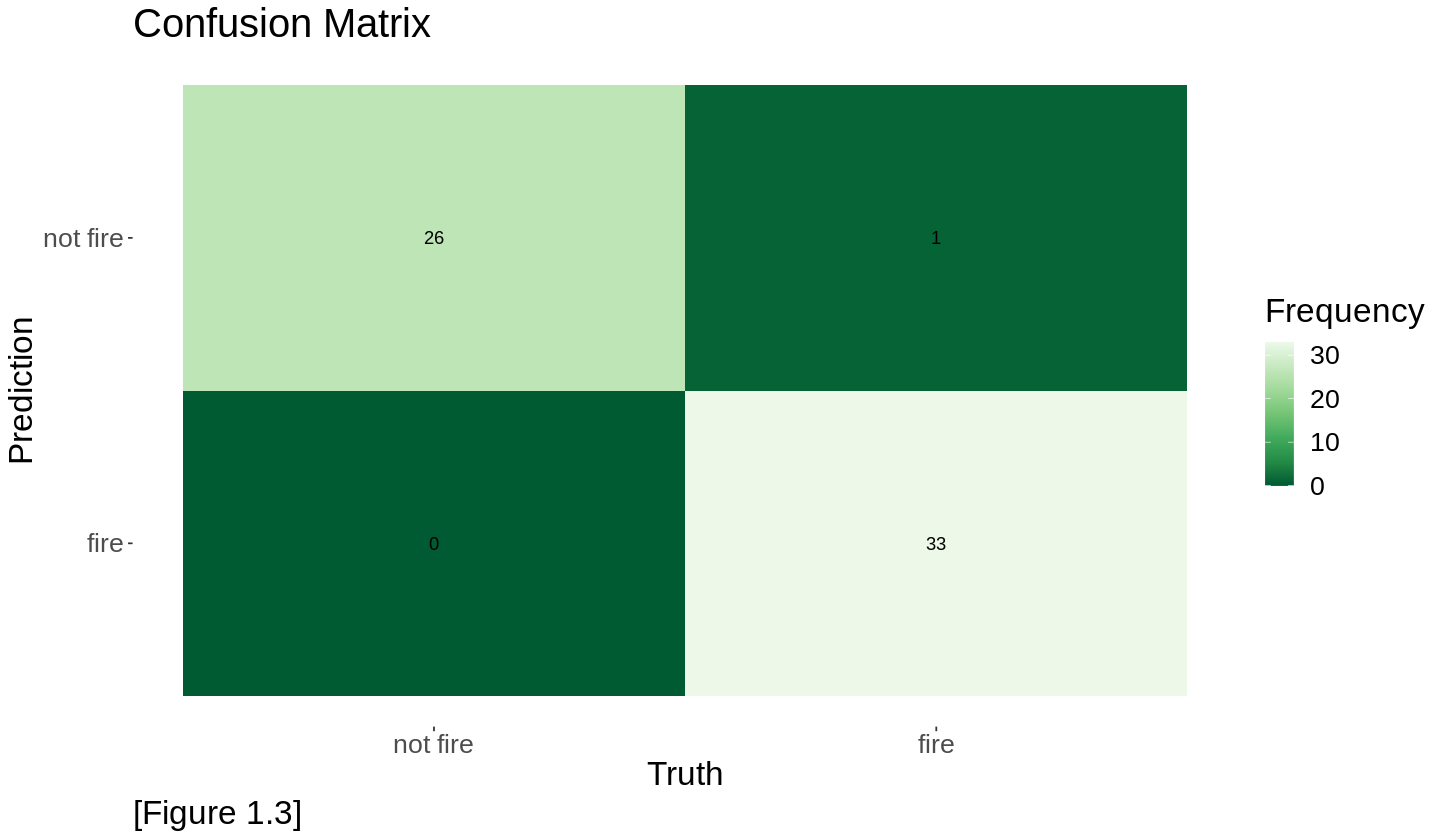

In [12]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

ff_fit <- workflow() %>%
  add_recipe(ff_recipe) %>%
  add_model(knn_best_spec) %>%
  fit(data = ff_train)

ff_predictions <- predict(ff_fit, ff_test) %>% 
    bind_cols(ff_test)

ff_acc <- ff_predictions %>% 
    metrics(truth = Classes, estimate = .pred_class) %>% 
    select(.metric, .estimate) %>% 
    head(1)

ff_cm <- ff_predictions %>% 
    conf_mat(truth = Classes, estimate = .pred_class)

autoplot(ff_cm, type = "heatmap") +
    scale_fill_distiller(palette = "Mint", name = "Frequency") + #color blind friendly
    labs(title = "Confusion Matrix", caption = "[Figure 1.3]") +
    theme(legend.position = "right", text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))

<div align="center"> Table 1.7 </div>

|.metric  | .estimate|
|:--------|---------:|
|accuracy | 0.9833333|

* Now, we conduct our KNN classification on the test set with the help of our trained model.
* It is observed in Table 1.7 that the accuracy of our predictions was extremely high at 98%.
* In order to visualize the results, we also created a confusion matrix represented in Figure 1.3. It can be deduced from this matrix that a total of 59 out of the 60 predictions were true. Only in one case where the actual class was "fire" did our model falsely predict "not fire".

## Discussion

As evident through our analysis mentioned above, our model has shown that the best predictor variables to that of forest fires are FFMC (Fine Fuel Moisture Code), ISI (Initial Spread Index), and Rain – racking a 98.33% accuracy level as depicted in Table 1.7. This is the highest among other predictors with at least 2 variables tested. Our team initially did not expect to find such results given the nature of FFMC and ISI that fall under our non-independent classifications as mentioned in our project proposal. Nevertheless, after performing additional research to support our analysis, we now understand that FFMC is derived from a combination of variables ranging from historical measurement of temperature, humidity, wind speed, and 24-hour precipitation (Amiro, Logan, Wotton, et al., 2005). This essentially makes FFMC the prominent variable in predicting whether a forest fire might occur. Coupling the respective variables with both ISI and Rain Forecast Index allows our model to further predict additional information such as the extent and size of the forest fire. On the other hand, we also show in our analysis that FFMC has the highest predictive accuracy of 98.34% (shown in Table 1.6) out of all the predictor variables; however, we decided not to choose a single predictor as it may cause some variability in the prediction since our model will be rooted in merely one predictor. 

Wrangling and analyzing all the given variables in the dataset allows us to carefully examine how each of the variables correlates with one another. Our findings will definitely augment the capability of the Algerian authorities, especially in the Bejaia and Sidi-Bel Abbes region, to clamp down the number of forest fires, damages to human lives, infrastructure, and the environment that will happen in the future through the use of three predictor variables mentioned above.

Some future questions and researches that our analysis could lead to are as follows:
1.    Can our model be implemented if presented with an observation from another country/climate region? How should we adjust our data accordingly? Can we extrapolate?
2.    How can we combine our analysis with that of the metrics that the real world is currently using to develop a better forest fire prevention system?

## References

Faroudja ABID et al. , â€œPredicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithmâ€, International Conference on Advanced Intelligent Systems for Sustainable Development (AI2SD 2019) , 08 - 11 July , 2019, Marrakech, Morocco.

Amiro, B., Logan, K., Wotton, M., Flannigan, M., Todd, J., Stocks, B., Martell, D. (2005). Fire weather index components for large fires in the Canadian boreal forest. International Journal of Wildland Fire. 13. 391-400. 10.1071/WF03066.

Curt, T., Aini, A., Dupire, S. (2020). Fire Activity in Mediterranean Forests (The Algerian Case). Fire 2020, 3, 58. https://doi/: 10.3390/fire3040058

Rishickesh, R., Shahina, A., Khan, A. (2019). Predicting Forest Fires using Supervised and Ensemble Machine Learning Algorithms. https://doi/: 10.35940/ijrte.B2878.078219

Vitolo, C., Di Giuseppe, F., Krzeminski, B., & San-Miguel-Ayanz, J. (2019). A 1980-2018 global fire danger re-analysis dataset for the Canadian Fire Weather Indices. Scientific data, 6, 190032. https://doi.org/10.1038/sdata.2019.32